# My attempt on building a recommendation system with LightFM

Import necessary libraries

In [31]:
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

from lightfm.data import Dataset

Read dataframes

In [4]:
authors = pd.read_csv("../data/external/general_recs/authors.csv", index_col=0)
submissions = pd.read_csv("../data/external/general_recs/cf-cpp-submissions-wo-code.csv", index_col=0)
problems = pd.read_csv("../data/external/general_recs/final_df.csv", index_col=0)

Drop useless column

In [8]:
authors.drop(columns=["full_name"], inplace=True)

## Data Analysis

In [9]:
authors.head()

,author,author_url,rating,rating_text,city,country,organization,contribution,friend_of,rating_max,rating_max_text,registered
1,anubhav360,/profile/anubhav360,1199.0,newbie,NaN,NaN,NaN,0.0,0.0,1393.0,pupil,Aug/22/2019 15:09
2,little_waxberry,/profile/little_waxberry,2186.0,master,Nanjing,China,Nanjing Foreign Language School,0.0,191.0,2186.0,master,Mar/20/2017 02:10
3,saurabhnewatiya,/profile/saurabhnewatiya,1259.0,pupil,Kanpur,India,"Jaypee Institute of Information Technology,Noida",0.0,34.0,1406.0,specialist,Aug/18/2018 17:31
4,mp13,/profile/mp13,929.0,newbie,Mumbai,India,Dwarkadas J. Sanghvi College of Engineering,0.0,1.0,1362.0,pupil,Nov/18/2019 13:42
5,sachi1325,/profile/sachi1325,1417.0,specialist,NaN,NaN,NaN,0.0,2.0,1495.0,specialist,Sep/24/2010 13:48


In [11]:
authors.describe()

,rating,contribution,friend_of,rating_max
count,341323.000000,348475.000000,348475.000000,341323.000000
mean,1252.809272,0.240075,12.821431,1357.588873
std,395.505409,4.364203,111.815511,393.694496
min,-47.000000,-139.000000,0.000000,346.000000
25%,998.000000,0.000000,0.000000,1181.000000
50%,1286.000000,0.000000,2.000000,1410.000000
75%,1468.000000,0.000000,8.000000,1536.000000
max,3796.000000,196.000000,42215.000000,3979.000000


In [21]:
authors_cat = authors

authors_cat["cat"] = pd.Categorical(authors.rating_text)

<Axes: >

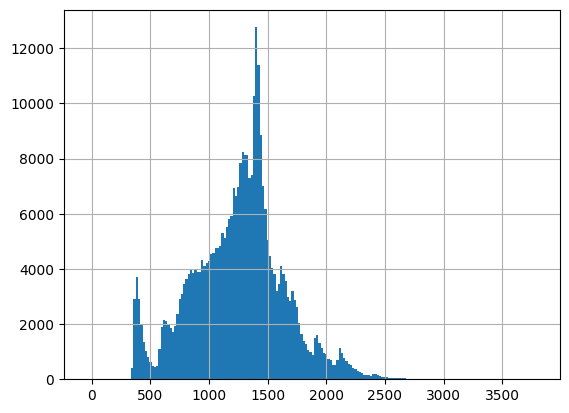

In [38]:
authors.rating.hist(bins=200)

<Axes: >

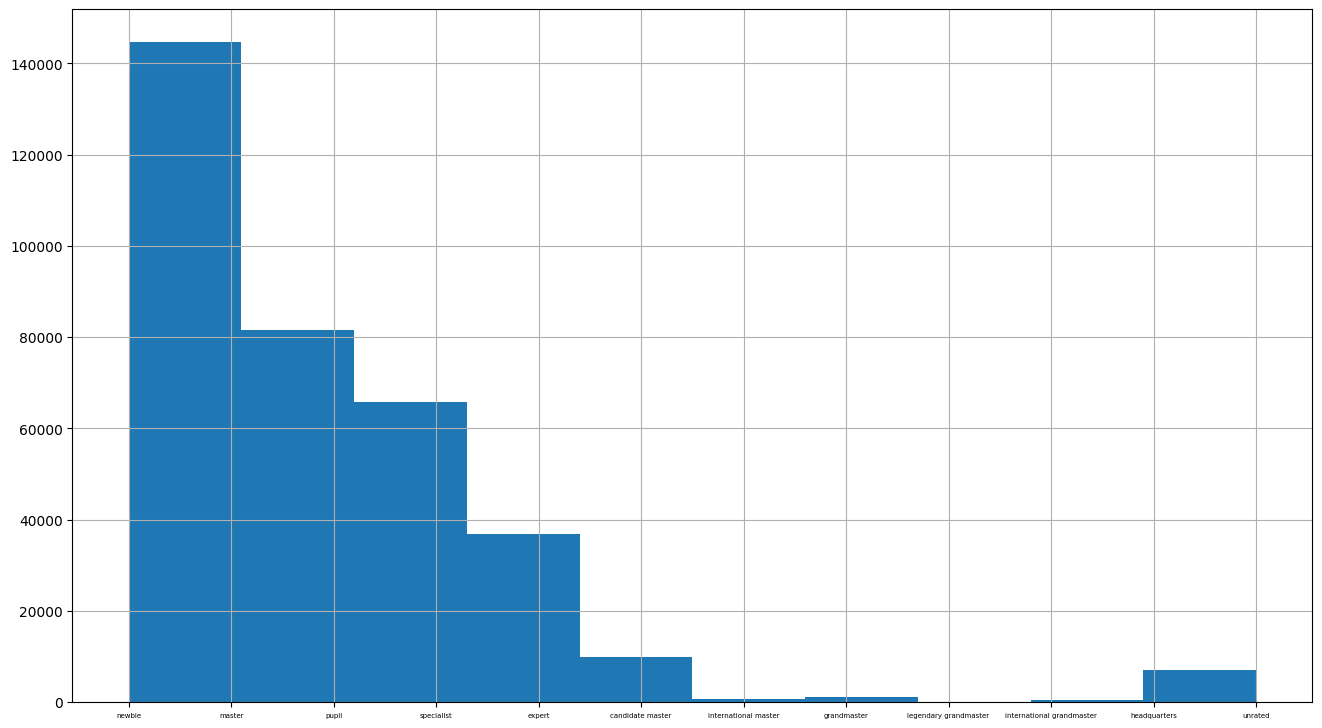

In [34]:
authors_cat["cat"].hist(figsize=(16, 9), xlabelsize=5)

In [13]:
authors.author_url.unique()

array(['/profile/anubhav360', '/profile/little_waxberry',
       '/profile/saurabhnewatiya', ..., '/profile/deniz15',
       '/profile/marchesin.angelo', '/profile/mikelsv'], dtype=object)

In [12]:
submissions.author_url.unique()

array(['/profile/PinkieDashForever', '/profile/cjtoribio',
       '/profile/miraliv', ..., '/profile/JLFPP', '/profile/lijunjin',
       '/profile/Aidana88888'], dtype=object)

In [18]:
authors_active = authors[authors.author_url.isin(submissions.author_url.unique())]

In [19]:
authors_active.author_url.unique()

array(['/profile/anubhav360', '/profile/little_waxberry',
       '/profile/saurabhnewatiya', ..., '/profile/levdmit-nn',
       '/profile/adumrewal', '/profile/mikelsv'], dtype=object)

In [44]:
for i in submissions.problem_url[:5]:
    print(repr(i))

'/contest/127/problem/A'
'/contest/127/problem/B'
'/contest/127/problem/C'
'/contest/127/problem/D'
'/contest/127/problem/E'


## Building the dataset

### Add users and items

In [151]:
ds = Dataset()



In [48]:
problems.head()

,contest_id,index,problem_url,level_0,name,points,tags,tag_ids,rating
0,325,A,/contest/325/problem/A,7149.0,Квадрат и прямоугольники,500.0,['implementation'],[23],1500.0
1,325,B,/contest/325/problem/B,7148.0,Стадион и игры,1000.0,"['binary search', 'math']","[3, 25]",1800.0
2,325,C,/contest/325/problem/C,7147.0,Монстры и бриллианты,2000.0,"['dfs and similar', 'graphs', 'shortest paths']","[10, 20, 31]",2600.0
3,325,D,/contest/325/problem/D,7146.0,Царство и государство,2000.0,['dsu'],[13],2900.0
4,325,E,/contest/325/problem/E,7145.0,Тропинки и полянки,2500.0,"['combinatorics', 'dfs and similar', 'dsu', 'g...","[7, 10, 13, 20, 21]",2800.0


Add even more problems

In [50]:
ds.interactions_shape()

(304205, 10213)

### Add features

#### Fill N/A

In [114]:
(problems[problems["index"].str.slice(stop=1) == "D"].rating.median(),
 problems[problems["index"].str.slice(stop=1) == "D"].rating.mean())

(2000.0, 2078.8929440389293)

In [80]:
problems["filled_rating"] = problems.apply(lambda row: row.rating if not row.rating != row.rating else problems[
    problems.rating.notna() & (problems["index"].str.slice(stop=1) == row["index"][:1])].rating.median(), axis=1)

In [82]:
problems[problems.rating.isna()]

,contest_id,index,problem_url,level_0,name,points,tags,tag_ids,rating,filled_rating
509,1356,A1,/contest/1356/problem/A1,2543.0,Distinguish I from X,NaN,['*special'],[1],NaN,1000.0
510,1356,A2,/contest/1356/problem/A2,2542.0,Distinguish I from Z,NaN,['*special'],[1],NaN,1000.0
511,1356,A3,/contest/1356/problem/A3,2541.0,Distinguish Z from S,NaN,['*special'],[1],NaN,1000.0
512,1356,A4,/contest/1356/problem/A4,2540.0,Distinguish I ⊗ X from CNOT,NaN,['*special'],[1],NaN,1000.0
513,1356,A5,/contest/1356/problem/A5,2539.0,Distinguish Z from -Z,NaN,['*special'],[1],NaN,1000.0
...,...,...,...,...,...,...,...,...,...,...
10102,1814,B,/contest/1814/problem/B,4.0,Длинные ноги,NaN,"['brute force', 'math']","[5, 25]",NaN,1400.0
10103,1814,C,/contest/1814/problem/C,3.0,Параллельный поиск,NaN,"['constructive algorithms', 'greedy', 'sortings']","[8, 21, 32]",NaN,1700.0
10104,1814,D,/contest/1814/problem/D,2.0,Балансировка пушек,NaN,"['binary search', 'brute force', 'math', 'two ...","[3, 5, 25, 37]",NaN,2000.0
10105,1814,E,/contest/1814/problem/E,1.0,Фишки на цепочке,NaN,"['data structures', 'dp']","[9, 12]",NaN,2400.0


In [97]:
problems["filled_points"] = problems.apply(lambda row: row.points if not row.points != row.points else problems[
    problems.points.notna() & (problems["index"].str.slice(stop=1) == row["index"][:1])].points.median(), axis=1)

In [98]:
problems[problems.points.isna()]

,contest_id,index,problem_url,level_0,name,points,tags,tag_ids,rating,filled_rating,filled_points
5,1,A,/contest/1/problem/A,8592.0,Театральная площадь,NaN,['math'],[25],1000.0,1000.0,500.0
6,1,B,/contest/1/problem/B,8591.0,Электронные таблицы,NaN,"['implementation', 'math']","[23, 25]",1600.0,1600.0,1000.0
7,1,C,/contest/1/problem/C,8590.0,Древнеберляндский цирк,NaN,"['geometry', 'math']","[18, 25]",2100.0,2100.0,1500.0
8,10,A,/contest/10/problem/A,8553.0,Учет энергопотребления,NaN,['implementation'],[23],900.0,900.0,500.0
9,10,B,/contest/10/problem/B,8552.0,Кассир в кинотеатре,NaN,"['dp', 'implementation']","[12, 23]",1500.0,1500.0,1000.0
...,...,...,...,...,...,...,...,...,...,...,...
10102,1814,B,/contest/1814/problem/B,4.0,Длинные ноги,NaN,"['brute force', 'math']","[5, 25]",NaN,1400.0,1000.0
10103,1814,C,/contest/1814/problem/C,3.0,Параллельный поиск,NaN,"['constructive algorithms', 'greedy', 'sortings']","[8, 21, 32]",NaN,1700.0,1500.0
10104,1814,D,/contest/1814/problem/D,2.0,Балансировка пушек,NaN,"['binary search', 'brute force', 'math', 'two ...","[3, 5, 25, 37]",NaN,2000.0,2000.0
10105,1814,E,/contest/1814/problem/E,1.0,Фишки на цепочке,NaN,"['data structures', 'dp']","[9, 12]",NaN,2400.0,2500.0


In [113]:
(problems[problems["index"].str.slice(stop=1) == "I"].points.median(),
 problems[problems["index"].str.slice(stop=1) == "I"].points.mean())

(4000.0, 4218.75)

In [64]:
problems[["filled_rating", "tags", "filled_points"]].apply(list, axis=1)

0                      [1500.0, ['implementation'], 500.0]
1              [1800.0, ['binary search', 'math'], 1000.0]
2        [2600.0, ['dfs and similar', 'graphs', 'shorte...
3                                [2900.0, ['dsu'], 2000.0]
4        [2800.0, ['combinatorics', 'dfs and similar', ...
                               ...                        
10102                  [nan, ['brute force', 'math'], nan]
10103    [nan, ['constructive algorithms', 'greedy', 's...
10104    [nan, ['binary search', 'brute force', 'math',...
10105                [nan, ['data structures', 'dp'], nan]
10106    [nan, ['brute force', 'divide and conquer', 'd...
Length: 10107, dtype: object

In [174]:
authors_active.rating_text.value_counts()

rating_text
newbie                       113995
pupil                         67222
specialist                    55701
expert                        35246
candidate master               9708
master                         6178
unrated                        3165
grandmaster                    1085
international master            800
international grandmaster       450
legendary grandmaster            93
headquarters                      2
Name: count, dtype: int64

In [182]:
authors_active[authors_active.rating_text == 'unrated'].rating.isna().value_counts()

rating
True     3164
False       1
Name: count, dtype: int64

In [121]:
def create_features(dataframe, features_names, id_col_name):
    """
    Generate features that will be ready for feeding into lightfm

    Parameters
    ----------
    dataframe: Dataframe
        Pandas Dataframe which contains features
    features_names : List
        List of feature columns name available in dataframe
    id_col_name: String
        Column name which contains id of the question or
        answer that the features will map to.
        There are two possible values for this variable.
        1. questions_id_num
        2. professionals_id_num

    Returns
    -------
    Pandas Series
        A pandas series containing process features
        that are ready for feed into lightfm.
        The format of each value
        will be (user_id, ['feature_1', 'feature_2', 'feature_3'])
        Ex. -> (1, ['military', 'army', '5'])
    """

    features = dataframe[features_names].apply(list, axis=1)

    features = list(zip(dataframe[id_col_name], features))
    return features

In [116]:
def generate_features(dataframe, features_names):
    """
    Generate features that will be ready for feeding into lightfm

    Parameters
    ----------
    dataframe: Dataframe
        Pandas Dataframe which contains features
    features_names : List
        List of feature columns name available in dataframe
    id_col_name: String
        Column name which contains id of the question or
        answer that the features will map to.
        There are two possible values for this variable.
        1. questions_id_num
        2. professionals_id_num

    Returns
    -------
    Pandas Series
        A pandas series containing process features
        that are ready for feed into lightfm.
        The format of each value
        will be (user_id, ['feature_1', 'feature_2', 'feature_3'])
        Ex. -> (1, ['military', 'army', '5'])
    """

    features = dataframe[features_names].apply(
        list, axis=1)

    features = features.apply(pd.Series).stack().reset_index(drop=True)
    return features

In [127]:
generate_features(problems, ["filled_rating", "tags", "filled_points"]).head()

0                       1500.0
1           ['implementation']
2                        500.0
3                       1800.0
4    ['binary search', 'math']
dtype: object

In [152]:
ds.fit(
    (author for author in submissions.author_url),
    (problem for problem in submissions.problem_url),
    generate_features(authors_active, ["rating", "rating_text", "rating_max", "rating_max_text"]),
    generate_features(problems, ["filled_rating", "tags", "filled_points"])
)

In [155]:
ds.user_features_shape()

(304205, 307100)

In [156]:
ds.fit_partial(items=(url for url in problems.problem_url))

In [117]:
ds.fit_partial(item_features=generate_features(problems, ["filled_rating", "tags", "filled_points"]))

In [119]:
ds.item_features_shape()

(10213, 13037)

In [ ]:
ds.fit_partial(items=(url for url in problems.problem_url))

In [126]:
ds.fit_partial(
    user_features=generate_features(authors_active, ["rating", "rating_text", "rating_max", "rating_max_text"]))

In [125]:
authors_active.info()

<class 'pandas.core.frame.DataFrame'>
Index: 293645 entries, 1 to 367083
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   author           293643 non-null  object 
 1   author_url       293645 non-null  object 
 2   rating           290481 non-null  float64
 3   rating_text      293645 non-null  object 
 4   city             115900 non-null  object 
 5   country          93678 non-null   object 
 6   organization     74935 non-null   object 
 7   contribution     293645 non-null  float64
 8   friend_of        293645 non-null  float64
 9   rating_max       290481 non-null  float64
 10  rating_max_text  290481 non-null  object 
 11  registered       293645 non-null  object 
dtypes: float64(4), object(8)
memory usage: 29.1+ MB


In [128]:
ds.user_features_shape()

(304205, 307100)

In [142]:
for a in submissions[['author_url', 'problem_url']].values[:10]:
    print(a[0])

/profile/PinkieDashForever
/profile/PinkieDashForever
/profile/PinkieDashForever
/profile/PinkieDashForever
/profile/PinkieDashForever
/profile/cjtoribio
/profile/cjtoribio
/profile/cjtoribio
/profile/cjtoribio
/profile/cjtoribio


In [147]:
ds.mapping()[0]["/profile/PinkieDashForever"]

0

In [163]:
(interactions, weights) = ds.build_interactions(
    ((x[0], x[1]) for x in submissions[['author_url', 'problem_url']].values))

In [164]:
ds._user_feature_mapping

{'/profile/PinkieDashForever': 0,
 '/profile/cjtoribio': 1,
 '/profile/miraliv': 2,
 '/profile/adrian.jaskolka': 3,
 '/profile/majia5': 4,
 '/profile/daniel.anghel': 5,
 '/profile/rowdark': 6,
 '/profile/GarySham': 7,
 '/profile/vsavchenkov': 8,
 '/profile/NikitaD': 9,
 '/profile/SWATMaD': 10,
 '/profile/xDEMONx': 11,
 '/profile/UESTC_Defense': 12,
 '/profile/Nodar': 13,
 '/profile/amir_sh': 14,
 '/profile/stqn': 15,
 '/profile/apathism': 16,
 '/profile/DimaPhil': 17,
 '/profile/wack-a-mole': 18,
 '/profile/knock-knock': 19,
 '/profile/Landertxu': 20,
 '/profile/Kaga2s': 21,
 '/profile/Zool': 22,
 '/profile/LinKin': 23,
 '/profile/Auster': 24,
 '/profile/ipaljak': 25,
 '/profile/Blink': 26,
 '/profile/ItsLastDay': 27,
 '/profile/vagnard': 28,
 '/profile/shibly': 29,
 '/profile/HeroShadow': 30,
 '/profile/Jesus': 31,
 '/profile/husheyn': 32,
 '/profile/tokoharu': 33,
 '/profile/eagletmt': 34,
 '/profile/D.M.': 35,
 '/profile/marim': 36,
 '/profile/spalac24': 37,
 '/profile/calflove': 38

In [183]:
user_features = ds.build_user_features((x[0], x[1:]) for x in authors_active[
    ["author_url", "rating", "rating_text", "rating_max", "rating_max_text"]].values if all([i == i for i in x[1:]]))

In [184]:
user_features

<304205x307100 sparse matrix of type '<class 'numpy.float32'>'
	with 1170227 stored elements in Compressed Sparse Row format>

In [187]:
item_features = ds.build_item_features((x[0], x[1:]) for x in problems[["problem_url", "filled_rating", "tags", "filled_points"]].values if all([i == i for i in x[1:]]))

In [188]:
item_features

<10213x13037 sparse matrix of type '<class 'numpy.float32'>'
	with 39482 stored elements in Compressed Sparse Row format>

## Building the model

In [194]:
ds._item_id_mapping

{'/contest/127/problem/A': 0,
 '/contest/127/problem/B': 1,
 '/contest/127/problem/C': 2,
 '/contest/127/problem/D': 3,
 '/contest/127/problem/E': 4,
 '/contest/746/problem/A': 5,
 '/contest/746/problem/B': 6,
 '/contest/746/problem/C': 7,
 '/contest/746/problem/D': 8,
 '/contest/746/problem/E': 9,
 '/contest/746/problem/F': 10,
 '/contest/746/problem/G': 11,
 '/contest/1043/problem/A': 12,
 '/contest/1043/problem/B': 13,
 '/contest/1043/problem/C': 14,
 '/contest/1043/problem/D': 15,
 '/contest/1043/problem/E': 16,
 '/contest/1043/problem/F': 17,
 '/contest/1229/problem/A': 18,
 '/contest/1229/problem/B': 19,
 '/contest/1229/problem/C': 20,
 '/contest/1229/problem/D': 21,
 '/contest/1229/problem/E1': 22,
 '/contest/1229/problem/E2': 23,
 '/contest/175/problem/B': 24,
 '/contest/175/problem/A': 25,
 '/contest/175/problem/C': 26,
 '/contest/175/problem/D': 27,
 '/contest/175/problem/E': 28,
 '/contest/1477/problem/A': 29,
 '/contest/1477/problem/B': 30,
 '/contest/1477/problem/C': 31,
 

In [160]:
from lightfm import LightFM

In [162]:
model = LightFM(no_components=150, learning_rate=0.05, loss="warp", random_state=2023)

In [189]:
model.fit(interactions, user_features, item_features, sample_weight=weights, epochs=5, num_threads=8, verbose=True)

Epoch: 100%|██████████| 5/5 [03:04<00:00, 36.98s/it]


In [192]:
authors_active[authors_active.author_url.str.contains("IRussianGamerI", regex=False)]

,author,author_url,rating,rating_text,city,country,organization,contribution,friend_of,rating_max,rating_max_text,registered
32071,IRussianGamerI,/profile/IRussianGamerI,1334.0,pupil,NaN,NaN,NaN,0.0,2.0,1479.0,specialist,Sep/23/2019 12:48


In [199]:
ds._user_id_mapping["/profile/IRussianGamerI"]

199000

In [204]:
ds._item_id_mapping

{'/contest/127/problem/A': 0,
 '/contest/127/problem/B': 1,
 '/contest/127/problem/C': 2,
 '/contest/127/problem/D': 3,
 '/contest/127/problem/E': 4,
 '/contest/746/problem/A': 5,
 '/contest/746/problem/B': 6,
 '/contest/746/problem/C': 7,
 '/contest/746/problem/D': 8,
 '/contest/746/problem/E': 9,
 '/contest/746/problem/F': 10,
 '/contest/746/problem/G': 11,
 '/contest/1043/problem/A': 12,
 '/contest/1043/problem/B': 13,
 '/contest/1043/problem/C': 14,
 '/contest/1043/problem/D': 15,
 '/contest/1043/problem/E': 16,
 '/contest/1043/problem/F': 17,
 '/contest/1229/problem/A': 18,
 '/contest/1229/problem/B': 19,
 '/contest/1229/problem/C': 20,
 '/contest/1229/problem/D': 21,
 '/contest/1229/problem/E1': 22,
 '/contest/1229/problem/E2': 23,
 '/contest/175/problem/B': 24,
 '/contest/175/problem/A': 25,
 '/contest/175/problem/C': 26,
 '/contest/175/problem/D': 27,
 '/contest/175/problem/E': 28,
 '/contest/1477/problem/A': 29,
 '/contest/1477/problem/B': 30,
 '/contest/1477/problem/C': 31,
 

In [280]:
res = model.predict(ds._user_id_mapping["/profile/IRussianGamerI"], item_ids=list(ds._item_id_mapping.values()), item_features=list(ds._item_feature_mapping.items()))

AttributeError: 'list' object has no attribute 'tocsr'

In [270]:
print(res)

[-13.922911   -10.350857    -7.6710205  ...  -1.9641181    0.07243571
  -6.865121  ]


In [271]:
res.argmax()

4686

In [272]:
srt = res.argsort()

In [273]:
srt[-10:]

array([5349, 3250,  186, 1902, 4689,  968, 3492, 1052, 7812, 4686])

In [274]:
inverted = {}

for key, value in ds._item_id_mapping.items():
    inverted[value] = key

1459.9999999999998

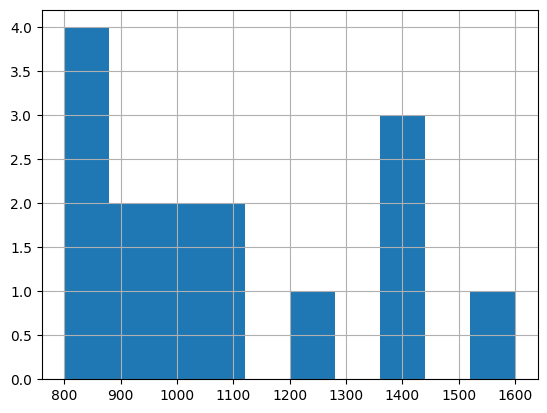

In [308]:
s = problems[problems.problem_url.isin(submissions[submissions.author_url=="/profile/IRussianGamerI"].problem_url)].rating

s.hist()

s.quantile(0.95)

In [341]:
for key in reversed(srt[-100:]):
    if len(problems[problems.problem_url==inverted[key]].filled_rating) and problems[problems.problem_url==inverted[key]].filled_rating.iat[0] >= s.quantile(0.9):
        print(f"https://codeforces.com{inverted[key]}", problems[problems.problem_url==inverted[key]].filled_rating)

https://codeforces.com/contest/1331/problem/D 5023    2000.0
Name: filled_rating, dtype: float64
https://codeforces.com/contest/1330/problem/B 5016    1400.0
Name: filled_rating, dtype: float64
https://codeforces.com/contest/1363/problem/B 575    1400.0
Name: filled_rating, dtype: float64
https://codeforces.com/contest/1327/problem/C 4994    1600.0
Name: filled_rating, dtype: float64
https://codeforces.com/contest/1228/problem/B 3806    1400.0
Name: filled_rating, dtype: float64
https://codeforces.com/contest/1191/problem/C 1080    1400.0
Name: filled_rating, dtype: float64
https://codeforces.com/contest/1368/problem/C 608    1500.0
Name: filled_rating, dtype: float64
https://codeforces.com/contest/1334/problem/C 5043    1600.0
Name: filled_rating, dtype: float64
https://codeforces.com/contest/1341/problem/C 5089    1500.0
Name: filled_rating, dtype: float64
https://codeforces.com/contest/1269/problem/B 8319    1500.0
Name: filled_rating, dtype: float64


In [332]:
draw = pd.DataFrame(submissions.problem_url.value_counts().reset_index())

In [ ]:
)

In [334]:
draw = pd.DataFrame(submissions.problem_url.value_counts())

draw["rating"] = draw["problem_url"].apply(lambda row: problems[problems.problem_url == row].filled_rating[0], axis=1)

KeyError: 'problem_url'